Run CCC analysis using LIANA+Tensorcell2cell to analyse communication between T cells (except gd) and DCs in the ABC and DT_ABC contexts. In this version, we add Macrophages and monocytes to the analysis. 

In [1]:
server = 'mando'
if (server == 'jabba'){
    data_path = '/data3/hratch/norcross_abc/'
    gpu_use = F
}else if (server == 'mando'){
    data_path = '/data/hratch/norcross_abc/'
    gpu_use = T
}

library(reticulate, quietly = T)
if (gpu_use){
    device<-'cuda:0'
    tensorly <- reticulate::import('tensorly')
    tensorly$set_backend('pytorch')
}else{
    device<-NULL
}

n.cores<-30
env_name = 'norcross_abc'

In [2]:
suppressPackageStartupMessages({
    suppressWarnings({
        library(liana, quietly = T)
        library(decoupleR, quietly = T)

        library(Seurat, quietly = T)
        
        library(dplyr, quietly = T)
        library(tidyr, quietly = T)
        library(magrittr, quietly = T)
        library(tibble, quietly = T)
        library(reshape2, quietly = T)
        library(stringr)
        
        library(ggplot2, quietly = T)
        library(circlize, quietly = T)
        
        # library(textshape, quietly = T)
        c2c <- reticulate::import(module = "cell2cell", as="c2c")
    })
})

Set the pipeline parameters (things we can potentially adjust to get different outputs):

In [3]:
params<-list(return_all = FALSE, #whether to return all LRs in liana after filtering for expr_prop
             filter_specificity = FALSE, # whether to filter scores by specificty
             filter_thresh = 0.05, # specificity filter threshold
             filter_specificity_how = 'fill', # or exclude -- fill insignifanct interactions with min or remove alltogether
             lr_fill_by = NaN, # or 0 or NaN -- what to use in the lr_fill tc2c argument
             how = 'outer' # what to use in the how tc2c argument
            )

Load the data:

In [4]:
abc.integrated<-readRDS(paste0(data_path, 'processed/abc_annotated.RDS'))

Subset to the cell types and contexts of interest:

In [5]:
cell.types<-c('T-cells', 'cDC_1', 'cDC_2', 'Xcr1+ DC_1', 'Xcr1+ DC_2', 'pDC', 'ncMono', 'Mf')
contexts<-c('ABC', 'DT_ABC')
abc.ccc<-subset(abc.integrated, subset = (Cell.Type.Level1 %in% cell.types) & (Cell.Type.Level2 != 'gd-T') &
                                        (orig.ident %in% contexts))
Idents(abc.ccc)<-'Cell.Type.Level2'

Format to input to LIANA:

In [6]:
# format into sce object
DefaultAssay(abc.ccc)<-'RNA'
abc.ccc@meta.data <-abc.ccc@meta.data %>% droplevels()
abc.ccc.sce<-Seurat::as.SingleCellExperiment(abc.ccc)

In [7]:
# map LIANA consensus resource to mouse
suppressMessages({
    suppressWarnings({
        op_resource <- liana::select_resource("Consensus")[[1]]

        # Generate orthologous resource
        ortholog_resource <- liana::generate_homologs(op_resource = op_resource,
                                               target_organism = 10090) # mouse
    })
})

Run liana for each context and calculate the consensus rank score:

In [8]:
# suppressWarnings({
#     abc.ccc.sce<-liana_bysample(sce = abc.ccc.sce, 
#                idents_col = 'Cell.Type.Level2', 
#                sample_col = 'orig.ident',
#                assay.type='logcounts', # log-normalized counts
#                verbose = T, 
#               aggregate_how = 'both', # consensus magnitude AND specifity score
#                 resource = 'custom', 
#                 external_resource = ortholog_resource, # consensus resource in mouse
#                min_cells = 5, # default min cells to be considered
#                expr_prop = 0.05, # expressed in atleast 5% of cells to be scored
#                return_all = params$return_all, # assign a low score to those that don't pass expr_prop
#                 parallelize = TRUE, workers = n.cores,
#               )
# })
# saveRDS(abc.ccc.sce@metadata$liana_res, paste0(data_path, 'interim/', 'v2_liana_bysample.rds'))

abc.ccc.sce@metadata$liana_res<-readRDS(paste0(data_path, 'interim/', 'v2_liana_bysample.rds'))

If filtering for specificity rank, will change # of interactions in the contexts as follows:

In [9]:
sapply(abc.ccc.sce@metadata$liana_res, function(x) dim(x)[[1]])
       
if (params$filter_specificity_how == 'exclude'){
        sapply(abc.ccc.sce@metadata$liana_res, function(x) dim(x[x$specificity_rank <= params$filter_thresh, ])[[1]])
    }else if (params$filter_specificity_how == 'fill'){
        sapply(abc.ccc.sce@metadata$liana_res, function(x) dim(x[x$specificity_rank > params$filter_thresh, ])[[1]])
    }


ABC DT_ABC 
 56311  49054

ABC DT_ABC 
 45137  40384

In [10]:
print('stop point')

[1] "stop point"


In [11]:
if (params$filter_specificity){
    liana_res<-list()
    for (sample.name in names(abc.ccc.sce@metadata$liana_res)){
        x<-abc.ccc.sce@metadata$liana_res[[sample.name]]
        if (params$filter_specificity_how == 'exclude'){
            x<-x[x$specificity_rank <= params$filter_thresh, ] # eliminate those under threshold
        }else if (params$filter_specificity_how == 'fill'){
            x[x$specificity_rank > params$filter_thresh, 'magnitude_rank']<-max(x$magnitude_rank) # replace with "lowest" value (max because magnitude rank orders lower values as higher importance)
        }
        abc.ccc.sce@metadata$liana_res[[sample.name]]<-x
    }
}

Run Tensor-cell2cell

In [12]:
abc.ccc.sce@metadata$liana_res<-liana:::preprocess_scores(context_df_dict = abc.ccc.sce@metadata$liana_res, 
                                 score_col = 'magnitude_rank', # score to preprocess
                                  outer_fraction = 1/3, # only keep cells/LRs present in atleast in 1/3 of contexts
                                                        # outer_fract shouldn't change things since there are only 3 samples
                                  invert = TRUE, # since magnitude has lower scores being more valuable
                                  invert_fun = function(x) 1-x, 
                                  non_negative = TRUE, # shouldn't effect things since all magnitude ranks are positive
                                  non_negative_fill = 0, 
                                  verbose = T
                                 )

Inverting `magnitude_rank`!

Inverting `magnitude_rank`!



In [13]:
score_col = 'magnitude_rank'

if (params$lr_fill_by == 'min'){
    lr.fill.value<-min(sapply(abc.ccc.sce@metadata$liana_res, function(x) min(x[[score_col]])))
}else if (is.numeric(params$lr_fill_by)){
    lr.fill.value<-params$lr_fill_by
}
lr.fill.value

[1] NaN

In [14]:
# # build tensor
# tensor <- liana::liana_tensor_c2c(sce = abc.ccc.sce,
#                                   context_df_dict = NULL, 
#                                   score_col = 'magnitude_rank', 
#                                   how = params$how, 
#                                   lr_fill = lr.fill.value,
#                                   cell_fill = 0, 
#                                   context_order = levels(abc.ccc.sce@colData$orig.ident), 
#                                   sort_elements = TRUE, 
#                                   conda_env = env_name, 
#                                   build_only = TRUE, 
#                                   device = device)

# # decompose tensor
# tensor<-liana::decompose_tensor(tensor = tensor, 
#                          rank = NULL, 
#                          tf_optimization = 'regular', # CHANGE TO ROBUST
#                          elbow_metric = 'error', # Metric to use in the elbow analysis.
#                          smooth_elbow = FALSE, # Whether smoothing the metric of the elbow analysis.
#                          upper_rank=25, # Max number of factors to try in the elbow analysis
#                          init = 'svd', # Initialization method of the tensor factorization
#                          factors_only = FALSE, 
#                         )
# reticulate::py_save_object(object = tensor, 
#                            filename = paste0(paste0(data_path, 'processed/', 'v2_ccc_tensor.pkl')))

tensor<-reticulate::py_load_object(paste0(paste0(data_path, 'processed/', 'v2_ccc_tensor.pkl')))

Warning message in exec(output, ...):
“`sce` was superseded by `context_df_dict`!”


[1] 0


Loading `norcross_abc` Conda Environment

Building the tensor using magnitude_rank...

Estimating ranks...

Decomposing the tensor...



# Downstream Analysis

In [15]:
write.csv(tensor$factors$interactions, 
          paste0(data_path, 'interim/', 'v2_lr_loadings.csv'))

In [16]:
# basic formatting
factors<-liana:::format_c2c_factors(tensor$factors)

# ordering categories
f.c<-factors$contexts
f.c[['context']]<-factor(f.c$context, levels(abc.ccc.sce@colData$orig.ident))
factors[['contexts']]<-f.c
for (ct in c('senders', 'receivers')){
    f.ct<-factors[[ct]]
    f.ct[['celltype']]<-factor(f.ct$celltype, levels(abc.ccc.sce@colData$Cell.Type.Level2))
    factors[[ct]]<-f.ct
}
abc.ccc.sce@metadata$tensor_res<-factors

abc.ccc.sce@colData[['group']] = abc.ccc.sce@colData[['orig.ident']] # must have a "group" for plotting

[1] "The identified tensor rank is 9"


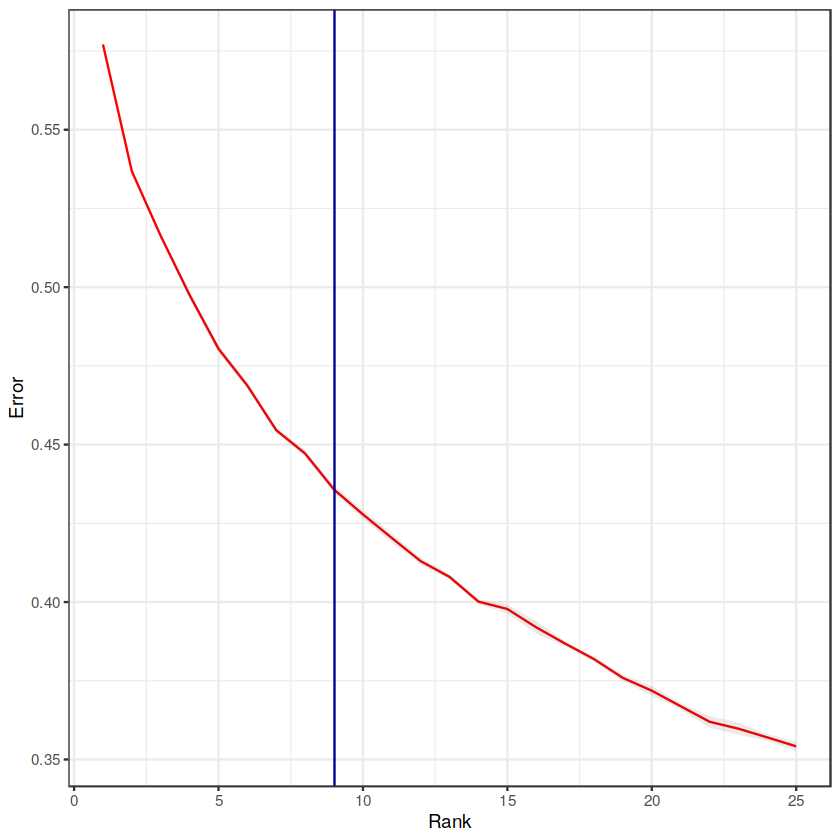

In [17]:
print(paste0('The identified tensor rank is ', tensor$rank))

# Estimate standard error
error_average <- tensor$elbow_metric_raw %>%
    t() %>%
    as.data.frame() %>%
    mutate(rank=row_number()) %>% 
    pivot_longer(-rank, names_to = "run_no", values_to = "error") %>%
    group_by(rank) %>%
    summarize(average = mean(error),
              N = n(),
              SE.low = average - (sd(error)/sqrt(N)),
              SE.high = average + (sd(error)/sqrt(N))
           )

# plot
error_average %>%
    ggplot(aes(x=rank, y=average), group=1) +
    geom_line(col='red') + 
    geom_ribbon(aes(ymin = SE.low, ymax = SE.high), alpha = 0.1) +
    geom_vline(xintercept = tensor$rank, colour='darkblue') + # rank of interest
    theme_bw() +
    labs(y="Error", x="Rank")

In [18]:
# addapt from liana
plot_c2c_overview <- function(sce, group_col, sample_col, factors.of.interest=NULL){

    factors <- get_c2c_factors(sce, group_col, sample_col)
    if (is.null(factors.of.interest)){
        factors.of.interest<-names(which(sapply(names(factors$contexts), function(x) startsWith(x, 'Factor.'))))
    }

    # Contexts
    contexts <- factors$contexts %>%
        pivot_longer(cols = -c("context", group_col),
                     names_to = "factor", values_to = "loadings"
        ) %>%
        filter(factor %in% factors.of.interest) %>%
        ggplot(aes(x=context, y=loadings, fill=.data[[group_col]])) +
        geom_bar(stat="identity") +
        facet_grid(factor ~ .) +
        theme_bw(base_size = 14) +
        theme(axis.title.x=element_blank(),
              axis.text.x=element_blank(),
              axis.ticks.x=element_blank(),
              strip.text.y = element_blank(),
              plot.title = element_text(hjust = 0.5)) +
        ggtitle('Contexts') +
        ylab(NULL)

    # lr
    lr <- factors$interactions %>%
        pivot_longer(-lr, names_to = "factor", values_to = "loadings") %>%
        filter(factor %in% factors.of.interest) %>%
        ggplot(aes(x=lr, y=loadings)) +
        geom_bar(stat="identity") +
        facet_grid(factor ~ ., scales = "free_y") +
        theme_bw(base_size = 14) +
        theme(axis.title.x=element_blank(),
              axis.text.x=element_blank(),
              axis.ticks.x=element_blank(),
              strip.background = element_blank(),
              strip.text.y = element_blank(),
              plot.title = element_text(hjust = 0.5)) +
        ggtitle('Interactions') +
        ylab(NULL)


    # Sender cells
    senders <- factors$senders %>%
        pivot_longer(cols = -celltype,
                     names_to = "factor", values_to = "loadings"
        ) %>%
        filter(factor %in% factors.of.interest) %>%
        ggplot(aes(x=celltype, y=loadings,
                   fill=celltype)) +
        geom_bar(stat="identity") +
        facet_grid(factor ~ .) +
        theme_bw(base_size = 14) +
        theme(axis.title.x=element_blank(),
              axis.text.x=element_blank(),
              axis.ticks.x=element_blank(),
              strip.background = element_blank(),
              strip.text.y = element_blank(),
              plot.title = element_text(hjust = 0.5)) +
        ylab(NULL) +
        ggtitle('Senders')

    # Receiver cells
    receivers <- factors$receivers %>%
        pivot_longer(cols = -celltype,
                     names_to = "factor", values_to = "loadings"
        ) %>%
        filter(factor %in% factors.of.interest) %>%
        ggplot(aes(x=celltype, y=loadings,
                   fill=celltype)) +
        geom_bar(stat="identity") +
        facet_grid(factor ~ .) +
        theme_bw(base_size = 14) +
        theme(axis.title.x=element_blank(),
              axis.text.x=element_blank(),
              strip.background = element_blank(),
              axis.ticks.x=element_blank(),
              strip.text.y = element_text(size=15, face = "bold"),
              plot.title = element_text(hjust = 0.5)) +
        ylab(NULL) +
        ggtitle('Receivers')

    # Assemble overview plot
    overview <- patchwork::wrap_plots(list(contexts,
                                           lr,
                                           senders,
                                           receivers
    ),
    ncol=4,
    nrow(1)) +
        patchwork::plot_layout(guides = "collect")

    grid::grid.draw(overview)
}

Warning message:
“Using an external vector in selections was deprecated in tidyselect 1.1.0.
ℹ Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(group_col)

  # Now:
  data %>% select(all_of(group_col))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.”


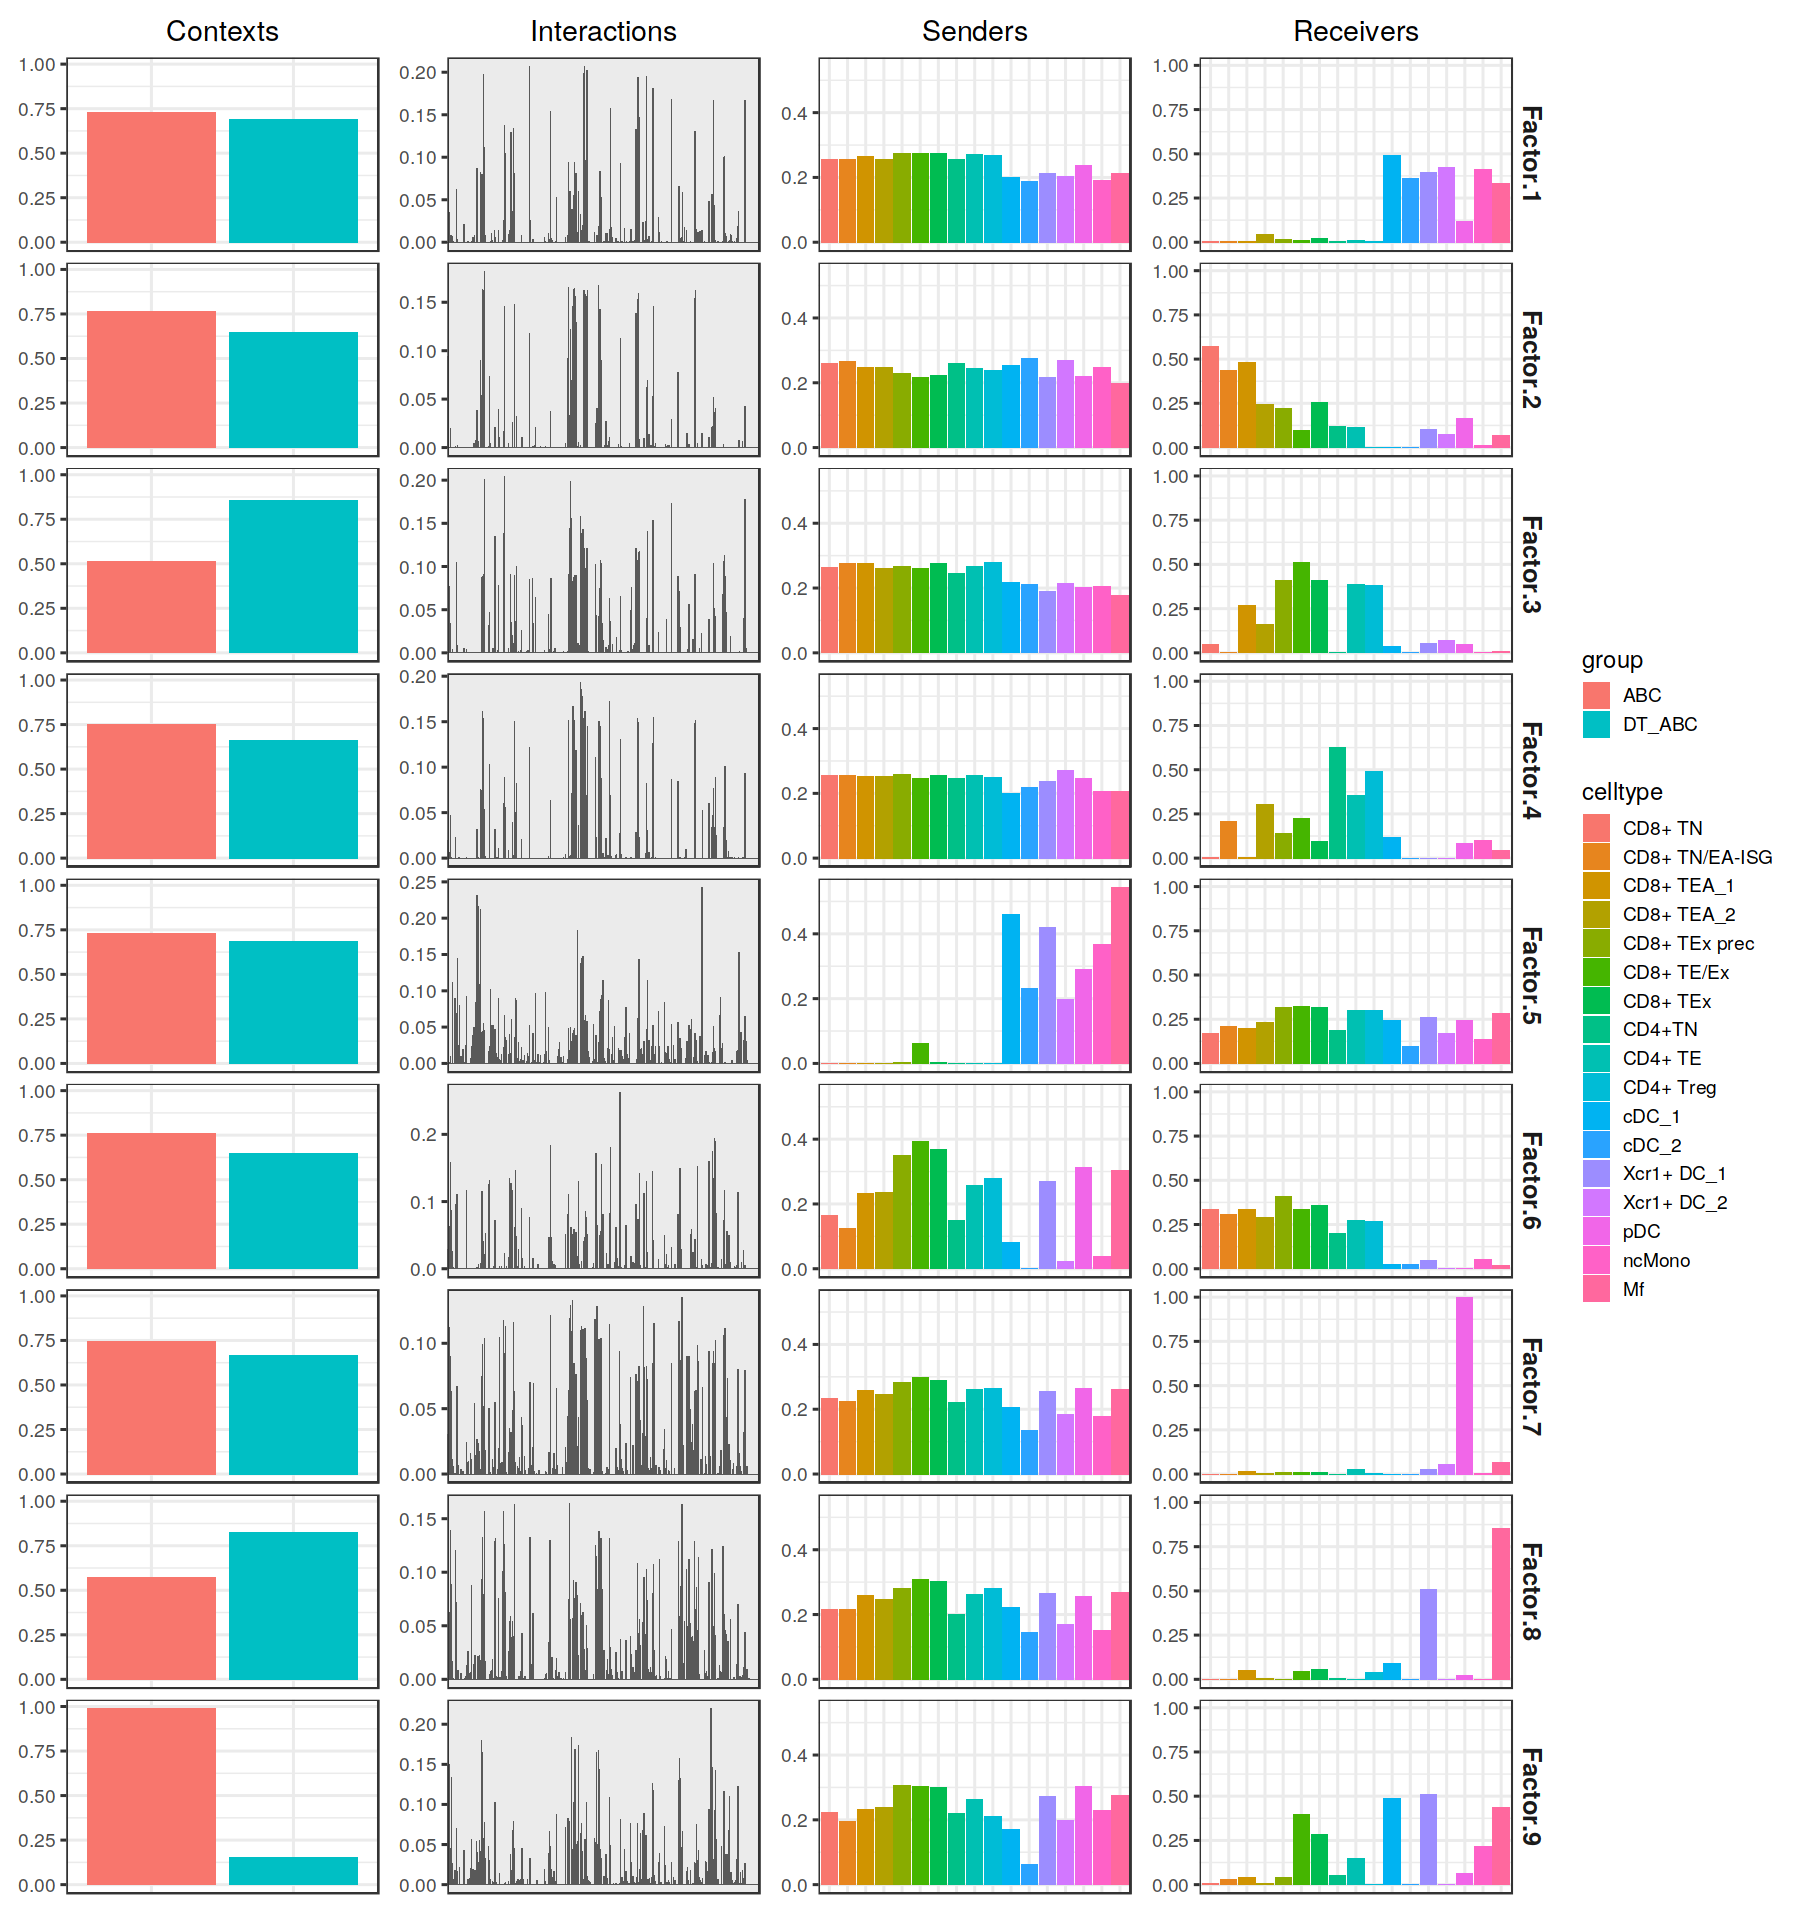

In [19]:
h_ = 16
w_ = 15
options(repr.plot.height=h_, repr.plot.width=w_)

plot_c2c_overview(sce = abc.ccc.sce, group_col = 'group', sample_col = 'orig.ident')

Context-specific factors are: Factors 3, 8 and 9

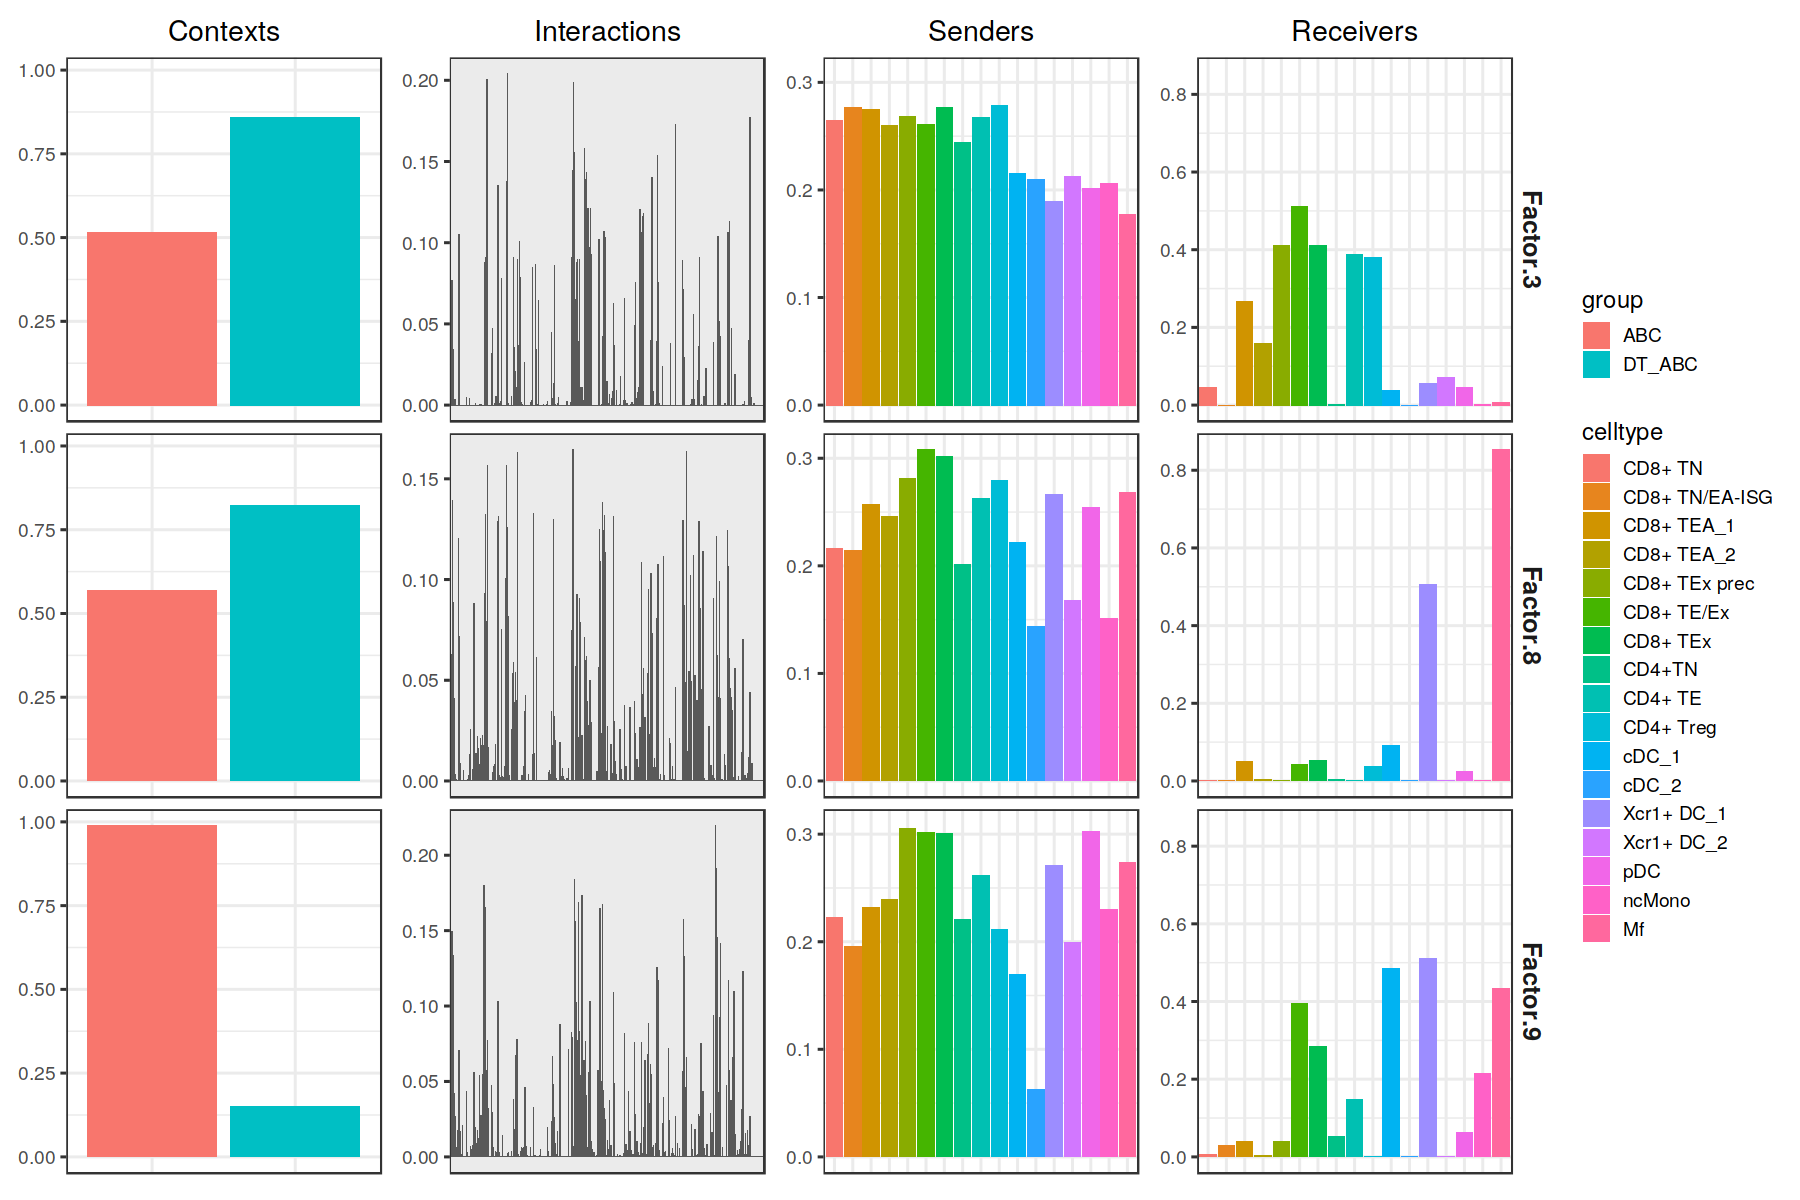

In [20]:
h_ = 10
w_ = 15
options(repr.plot.height=h_, repr.plot.width=w_)
fos<-c('3', '8', '9')
plot_c2c_overview(sce = abc.ccc.sce, group_col = 'group', sample_col = 'orig.ident', 
                 factors.of.interest = paste0('Factor.', fos))

In [21]:
calculate_gini(factors$senders) %>% arrange(gini)

factor,gini
<chr>,<dbl>
Factor.4,0.04662789
Factor.2,0.05245001
Factor.1,0.07457592
Factor.3,0.08376764
Factor.7,0.10152487
Factor.8,0.12061640
Factor.9,0.14044531
Factor.6,0.34656555
Factor.5,0.68959615


In [22]:
calculate_gini(factors$receivers) %>% arrange(gini)

factor,gini
<chr>,<dbl>
Factor.5,0.1723785
Factor.6,0.4520889
Factor.2,0.5527723
Factor.4,0.6069823
Factor.3,0.6185852
Factor.9,0.6444110
Factor.1,0.6505925
Factor.8,0.8695110
Factor.7,0.9298938


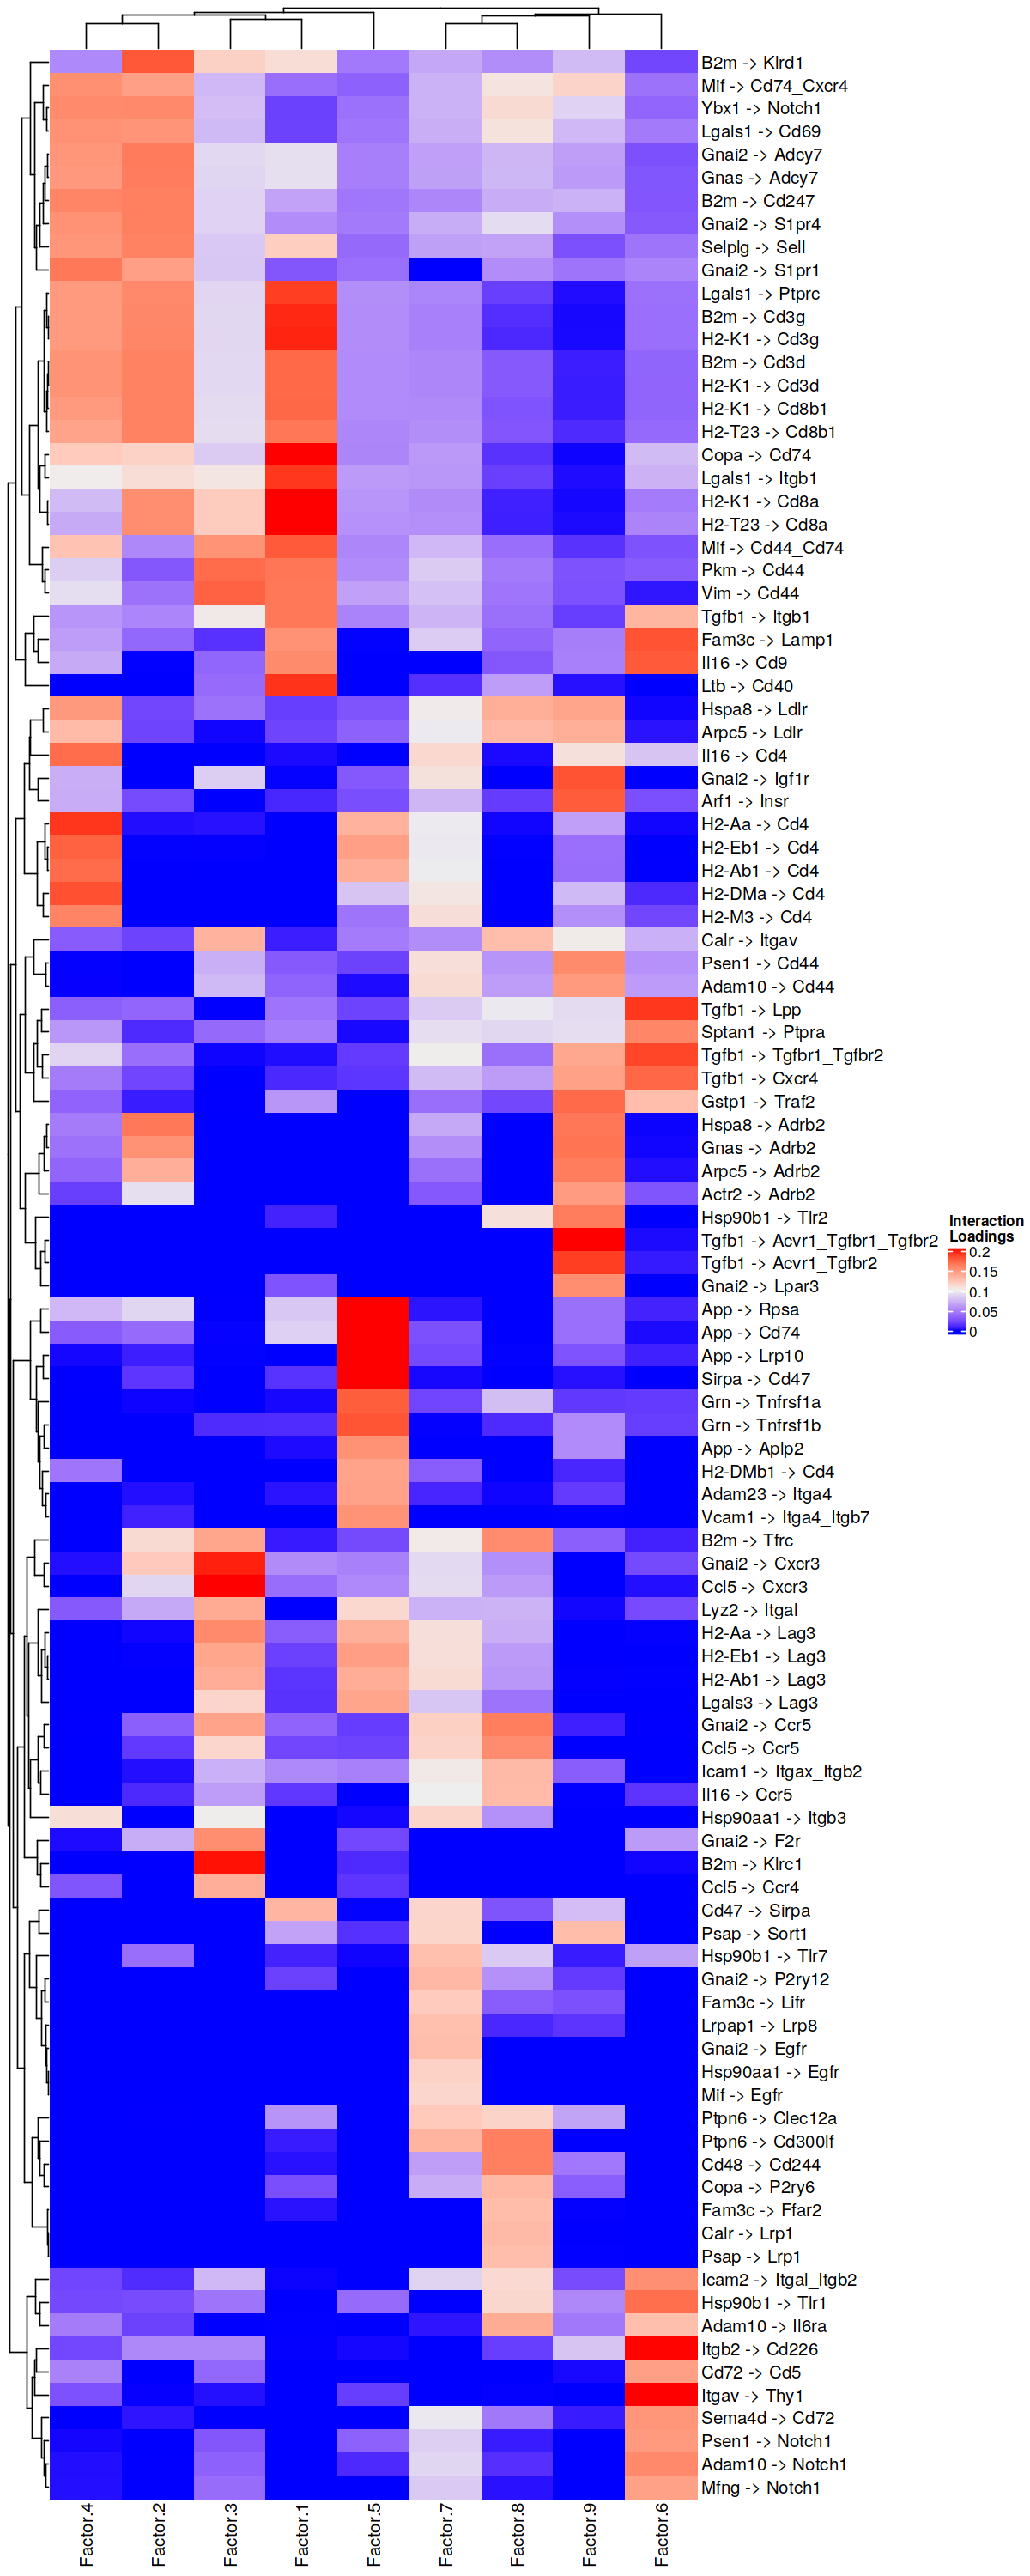

In [23]:
h_ = 25
w_ = 10
n_lrs<-15#5
options(repr.plot.height=h_, repr.plot.width=w_)
liana::plot_lr_heatmap(sce = abc.ccc.sce,  n = n_lrs)

In [24]:
top_lrs = list()
for (factor.name in paste0('Factor ', fos)){
    top_lrs[[factor.name]] = tensor$get_top_factor_elements(order_name='interactions', 
                                factor_name=factor.name, 
                                top_number=as.integer(n_lrs))
}
top_lrs


$`Factor 3`
   Ccl5^Cxcr3     B2m^Klrc1   Gnai2^Cxcr3      Vim^Cd44      Pkm^Cd44 
    0.2039229     0.2007087     0.1986094     0.1773518     0.1728444 
   H2-Aa^Lag3     Gnai2^F2r Mif^Cd44_Cd74    Gnai2^Ccr5   H2-Eb1^Lag3 
    0.1580753     0.1556377     0.1534079     0.1443791     0.1430090 
     B2m^Tfrc    Lyz2^Itgal   H2-Ab1^Lag3     Ccl5^Ccr4    Calr^Itgav 
    0.1428045     0.1404022     0.1387644     0.1377606     0.1353085 

$`Factor 8`
       Gnai2^Ccr5     Ptpn6^Cd300lf        Cd48^Cd244         Ccl5^Ccr5 
        0.1643898         0.1635698         0.1630565         0.1567327 
         B2m^Tfrc      Adam10^Il6ra        Hspa8^Ldlr        Copa^P2ry6 
        0.1567075         0.1393621         0.1382811         0.1325416 
       Arpc5^Ldlr Icam1^Itgax_Itgb2         Calr^Lrp1         Il16^Ccr5 
        0.1324826         0.1316305         0.1315347         0.1311606 
      Fam3c^Ffar2         Psap^Lrp1        Calr^Itgav 
        0.1299237         0.1291485         0.1290568 

$`Factor 9`
Tgfb1^Acvr1_Tgfbr1_Tgfbr2        Tgfb1^Acvr1_Tgfbr2               Gnai2^Igf1r 
                0.2195659                 0.1913889                 0.1836727 
                Arf1^Insr               Gstp1^Traf2                Gnas^Adrb2 
                0.1800842                 0.1735837                 0.1687490 
              Hspa8^Adrb2               Arpc5^Adrb2              Hsp90b1^Tlr2 
                0.1674912                 0.1651395                 0.1648572 
               Psen1^Cd44               Gnai2^Lpar3               Adam10^Cd44 
                0.1575894                 0.1557857                 0.1493177 
              Actr2^Adrb2               Tgfb1^Cxcr4                Hspa8^Ldlr 
                0.1489623                 0.1455712                 0.1431935

For each factor of interest, let's look at how the senders are interacting with teh receivers in more detail:

In [25]:
cc_plots<-list()
for (selected_factor in paste0('Factor.', fos)){
    cc_plots[[selected_factor]]<-liana::plot_c2c_cells(sce = abc.ccc.sce,
                                   factor_of_int = selected_factor,
                                    name = paste0(selected_factor, '\n', 
                                                 "Loadings Product"))    
}

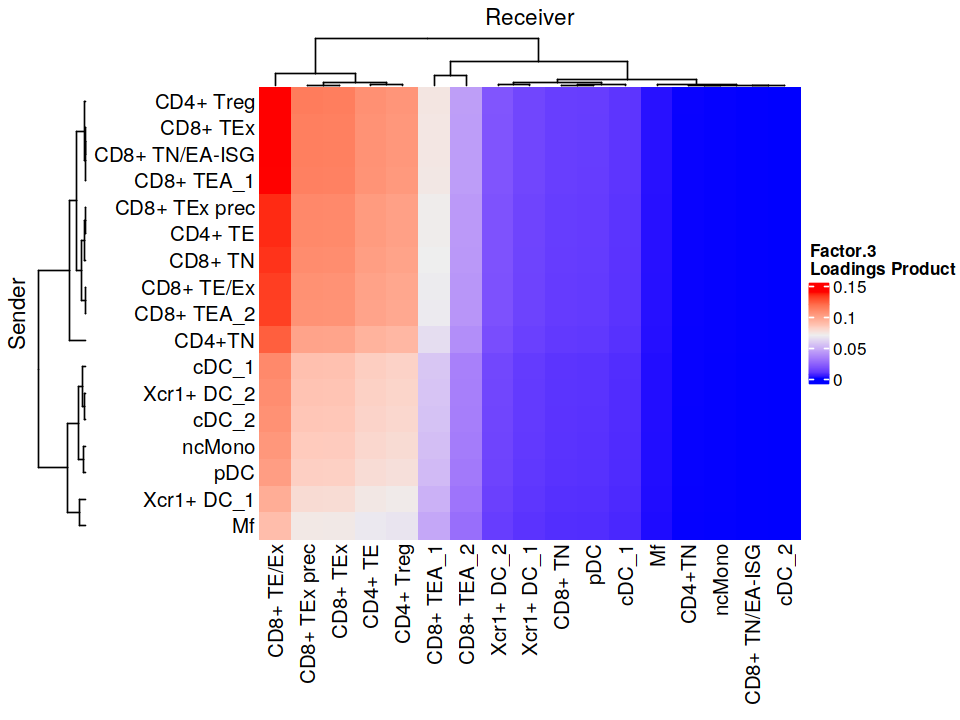

In [26]:
h_ = 6
w_ = 8
options(repr.plot.height=h_, repr.plot.width=w_)
i<-1
cc_plots[[i]]
i<-i+1

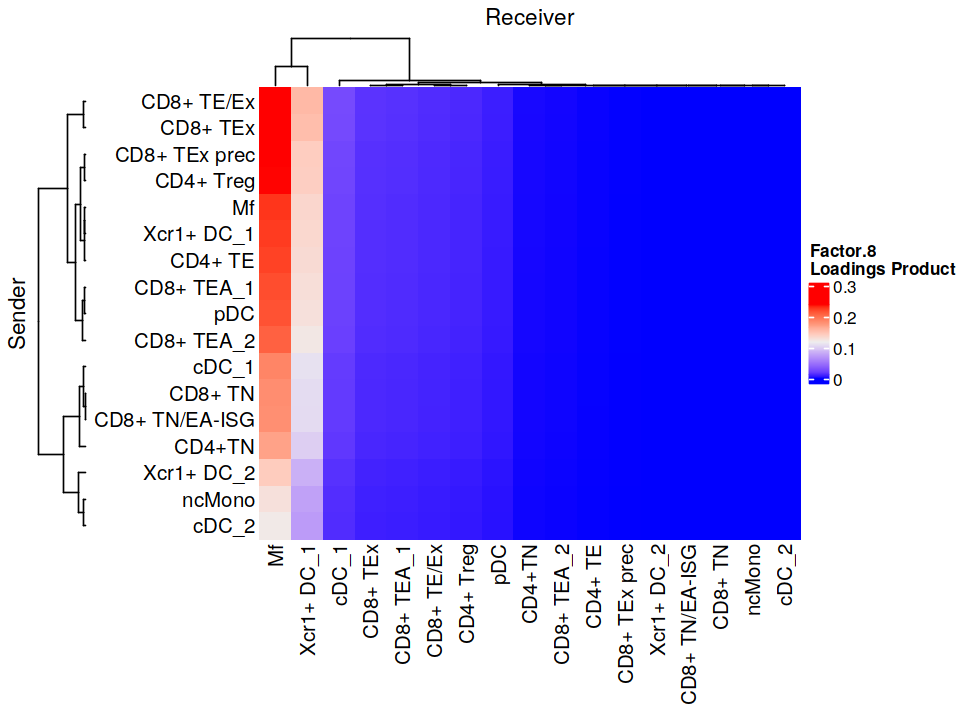

In [27]:
cc_plots[[i]]
i<-i+1

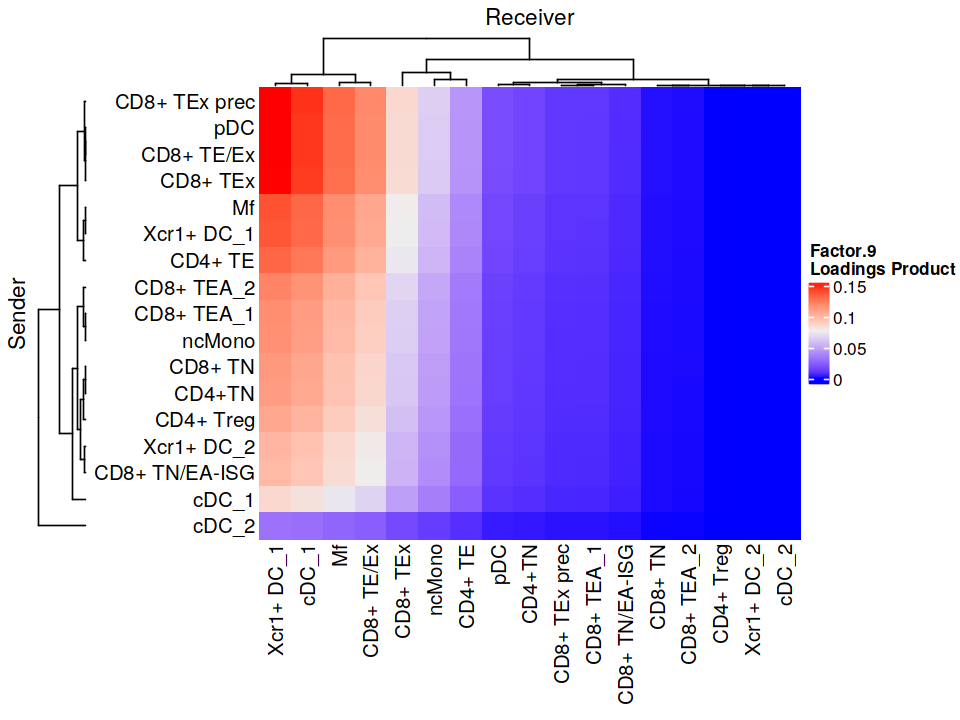

In [28]:
cc_plots[[i]]
i<-i+1

Let's take a look at the relationship between cell-cell and ligand receptor interactions:

In [29]:
get_joint_loadings<-function(tensor, selected_factor, dim1 = 'senders', dim2 = 'receivers'){
    
    v1<-tensor$factors[[dim1]][[selected_factor]]
    names(v1)<-rownames(tensor$factors[[dim1]])

    v2<-tensor$factors[[dim2]][[selected_factor]]
    names(v2)<-rownames(tensor$factors[[dim2]])
    
    return(outer(v1, v2, "*"))
}

get_lr_by_cell_pairs<-function(tensor, selected_factor, n_cci = NULL, n_lrs = NULL){
    sr<-get_joint_loadings(tensor, selected_factor, dim1 = 'senders', dim2 = 'receivers')
    
    # flatten
    sr<-as.vector(sr)
    element.names<-expand.grid(rownames(tensor$factors$senders), rownames(tensor$factors$receivers))
    element.names<-paste0(element.names[[1]], '->', element.names[[2]])
    names(sr)<-element.names
    
    if (!is.null(n_cci)){
#         sr<-sr[sr > cci_threshold]
        sr<-sort(sr, decreasing = T)[1:n_cci]
    }
    
    # get outer with lr
    v2<-tensor$factors$interactions[[selected_factor]]
    names(v2)<-rownames(tensor$factors$interactions) 
    if (!is.null(n_lrs)){
        v2<-sort(v2, decreasing = T)[1:n_lrs]
    }

    mat<-outer(sr, v2, "*")
    
    return(t(mat))
}

In [30]:
lr_cc_list<-list()
for (selected_factor in paste0('Factor ', fos)){
    mat<-get_lr_by_cell_pairs(tensor, selected_factor, n_cci = 30, n_lrs = 30)
    write.csv(mat, paste0(data_path, 'interim/', 'Factor', selected_factor, '_lr_by_cell.csv'))
    lr_cc_list[[selected_factor]]<-ComplexHeatmap::Heatmap(mat, 
                                                   name = paste0(selected_factor), 
                                                   column_title = "lr", row_title = 'cci')
}

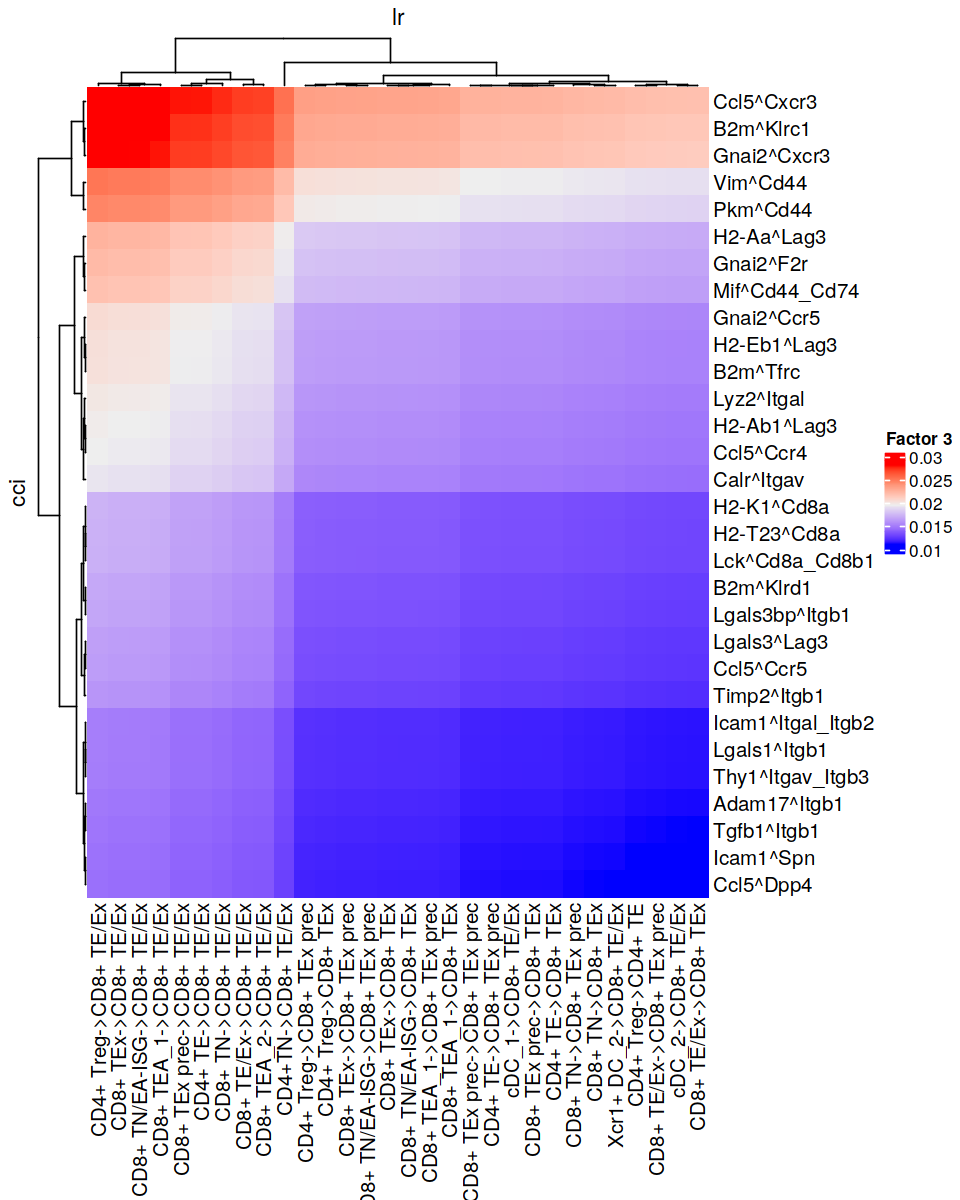

In [31]:
h_ = 10
w_ = 8
options(repr.plot.height=h_, repr.plot.width=w_)

i<-1
lr_cc_list[[i]]

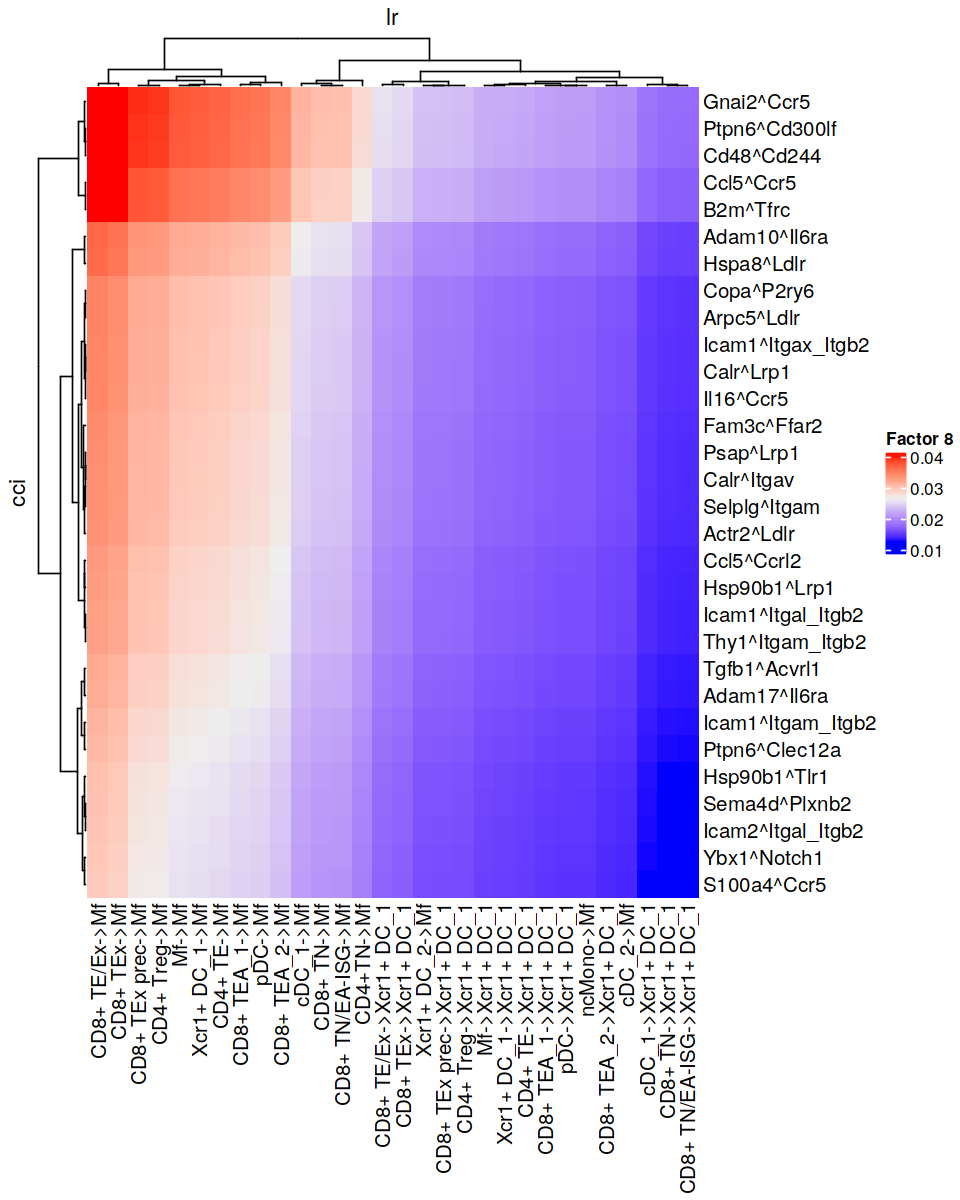

In [32]:
i<-i+1
lr_cc_list[[i]]

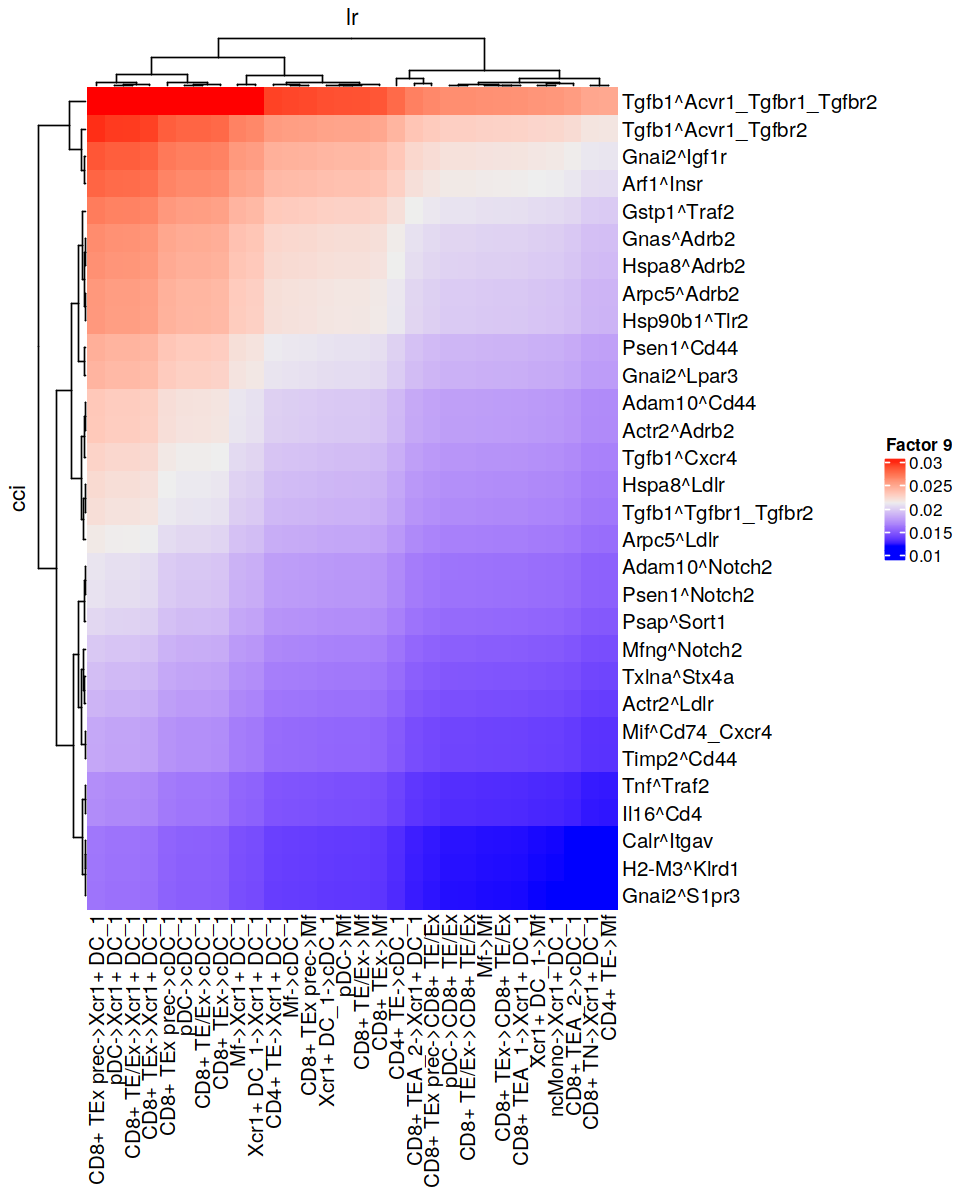

In [33]:
i<-i+1
lr_cc_list[[i]]

<span style="color:red">**Enrichment analysis must be refined a lot once specific factors are decided**

Finally, let's do an enrichment of the LRs for each of the context-specific Factors:

In [34]:
organism = 'mouse' 
pathwaydb = 'GOBP' # KEGG# can't use KEGG with mouse, may want to map ortholog

# lr_pairs <- liana::select_resource('Consensus')
# lr_pairs <- lr_pairs$Consensus[c('source_genesymbol', 'target_genesymbol')]
lr_pairs <- ortholog_resource[c('source_genesymbol', 'target_genesymbol')]
names(lr_pairs) <- c('ligand', 'receptor')
lr_list <- apply(lr_pairs, 1, function(x) paste0(x[[1]], '^', x[[2]]))
                 
lr_set <- c2c$external$generate_lr_geneset(lr_list = lr_list, 
                        complex_sep='_', # Separation symbol of the genes in the protein complex
                          lr_sep='^', # Separation symbol between a ligand and a receptor complex
                          organism=organism,
                          pathwaydb=pathwaydb,
                          readable_name=TRUE)    
lr_loadings = factors[['interactions']] %>% 
                column_to_rownames("lr")

In [35]:
gsea_res <- c2c$external$run_gsea(loadings=lr_loadings, 
                               lr_set=lr_set,
                               output_folder=paste0(data_path, 'interim/')
                              )
names(gsea_res)<-c('pvals', 'scores', 'gsea_df')

In [36]:
gsea.dotplot<-function(pval_df, score_df, significance = 0.05, font_size = 15){
    pval_df <- pval_df[apply(pval_df<significance,1,any), apply(pval_df<significance, 2, any)] %>% 
            mutate_all(function(x) -1*log10(x + 1e-9))
    score_df <- score_df[rownames(pval_df), colnames(pval_df)]
    pval_df <- pval_df %>%
                    tibble::rownames_to_column('Annotation')
    score_df <- score_df %>%
                    tibble::rownames_to_column('Annotation')

    viz_df <- cbind(melt(pval_df), melt(score_df)[[3]])
    names(viz_df) <- c('Annotation', 'Factor', 'Significance', 'NES')
    
                       
    dotplot <- ggplot(viz_df, aes(x = Factor, y = Annotation)) + geom_point(aes(size = Significance, color = NES)) + 
                scale_color_gradient2() + theme_bw(base_size = font_size) + 
                theme(axis.text.x = element_text(angle = 45, vjust = 0.5, hjust=0.5))+
                       scale_size(range = c(0, 8)) + 
                       guides(size=guide_legend(title="-log10(p-value)"))
    return(dotplot)
}

No significant hits...

In [38]:
min(min(gsea_res$pvals))

[1] 0.1050651

In [40]:
h_ = 8
w_ = 10
options(repr.plot.height=h_, repr.plot.width=w_)

dotplot <- gsea.dotplot(pval_df = gsea_res$pvals, 
                       score_df = gsea_res$scores, 
                       significance = 0.05)
dotplot

Now get downstream enriched genes:

In [41]:
# obtain progeny gene sets
progeny <- decoupleR::get_progeny(organism = 'mouse', top=5000) %>%
    select(-p_value)

# convert to LR sets
progeny_lr <- generate_lr_geneset(sce = abc.ccc.sce,
                                  resource = progeny)

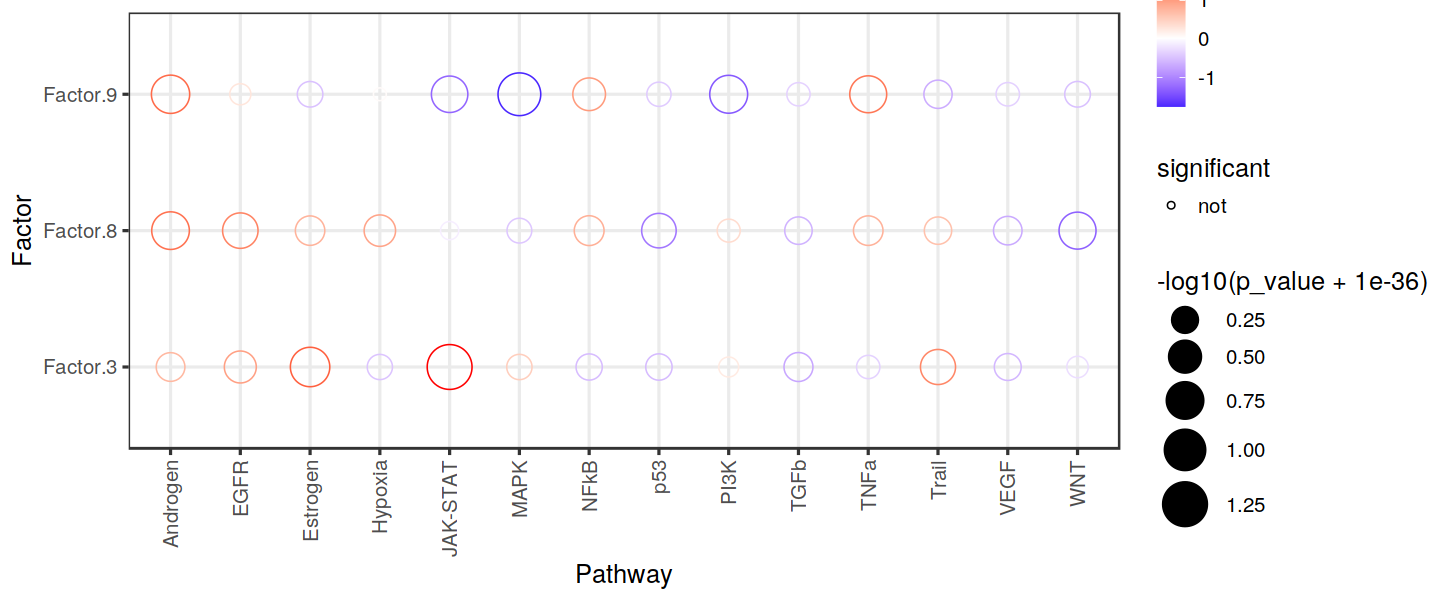

In [42]:
h_ = 5
w_ = 12
options(repr.plot.height=h_, repr.plot.width=w_)

# interaction loadings to matrix
mat <- factors$interactions[, c('lr', paste0('Factor.', fos))] %>%
    column_to_rownames("lr") %>%
  as.matrix()

# run enrichment analysis with decoupler
# (we fit a univariate linear model for each gene set)
# We don't consider genesets with minsize < 10
res <- decoupleR::run_ulm(mat = mat,
                          network = progeny_lr,
                          .source = "set",
                          .target = "lr",
                          minsize=10) %>%
  mutate(p_adj = p.adjust(p_value, method = "fdr"))

res %>% # sig/isnig flag
  mutate(significant = if_else(p_adj <= 0.1, "signif.", "not")) %>%
  ggplot(aes(x=source, y=condition, shape=significant,
             colour=score, size=-log10(p_value+1e-36))) +
  geom_point() +
  scale_colour_gradient2(high = "red", low="blue") +
  scale_size_continuous(range = c(3, 12)) +
  scale_shape_manual(values=c(21, 16)) +
  theme_bw(base_size = 15) +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
  labs(x="Pathway",
       y="Factor",
       colour="Activity"
       )

In [43]:
# progeny_lr[(progeny_lr$set == 'Estrogen') & (progeny_lr$mor > 0), ]

In [45]:
pathway = 'JAK-STAT'
factor = 'Factor.8'
# Plot LRs associated with Estrogen
lrs <-  factors$interactions %>%
  left_join(progeny_lr, by="lr") %>%
  filter(set==pathway) %>%
  select(lr, set, mor, loading = factor) %>%
  mutate(lr = gsub(as.character(str_glue("\\^")), " -> ", lr)) %>%
  mutate(weight = if_else(mor >= 0, "positive", "negative"))
lrs %>%
  # only label those that are > x
  mutate(lr = if_else(loading>=0.001 & abs(mor) > 2, lr, "")) %>%
  ggplot(aes(x=mor, y=loading, colour=weight)) +
  # label only top 20
  stat_smooth(method = "lm", col = "red") +
  geom_point(alpha = 0.5) + 
  ggrepel::geom_label_repel(aes(label = lr)) +
  theme_bw(base_size = 15) +
  scale_colour_manual(values = c("royalblue3", "red")) +
  labs(x="Pathway Weight", y="LR Loading")